## 나이 결측치 바꾼 파일 30대->20대

## 목차

#1. 데이터 준비 및 탐색 / Preparing dataset 


#2. 데이터 전처리 방법 & 이유 / Feature engineering & Feature selection 
#1) 유의미한 feature 선택하기 : Pclass, Sex, Age, SibSp&Parch, Embarked (5개 선택)
#2) 불필요한 칼럼 삭제


#3. 모델 적용 프로세스 및 결과 / 3개의 기본 모델 선택 (SVC, KNN, 의사결정나무)
#1) KNN 모델 
#2) SVC 모델 
#3) 의사결정나무
#4) XGBOOST
#5) Random Forest

#4. 모델 간 성능비교 / Predict on test data & Check the result with metrics
#1) KNN 모델, SVC모델, 의사결정나무, XGBOOST, Random Forest ( y_train / y_test : )


In [144]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn import ?
# from sklearn.metrics import ?


## 1. 데이터 준비 및 탐색 / Preparing dataset 

In [145]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [146]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [147]:
y_data = data_df[['Survived']]
y_data.head(3)

,Survived
0,0
1,1
2,1


In [148]:
# del data_df['Survived']
x_data = data_df.copy()
x_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2. 데이터 전처리 방법 & 이유 / Feature engineering & Feature selection 

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [149]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [150]:
# # 기본적인 결측치 채우는 방법
# mean_age = x_data['Age'].median(skipna=True)
# x_data['Age'] = x_data['Age'].fillna(mean_age) # or .fillna(int/float/str 값)

## 1) 유의미한 feature 선택하기 : Pclass, Sex, Age, SibSp&Parch, Embarked (5개 선택)

#1. 각 피처 분포를 바 그래프로 확인 

#2. survived랑 상관관계 찾기 -  crosstab이용해서 survived랑 해당 피처랑 상관관계 bar 그래프로 표현
- Pclass	
- Sex : 숫자로 바꾸기
- Age : 그룹화하기, 결측치는 사망자가 많은 28세로 채우기
- SibSp&Parch : 합해서 새로운열 만들기
- Embarked : 결측치는 빈도가 가장 높은 것으로 채우기
- Fare : 그룹화하기

#3. feature 선택 시 이슈 사항 및 가설
- Fare와 Cabin은 Pclass에 포함되는 개념이라고 생각 (Fare, Cabin < Pclass)
- Fare는 실습을 진행했으나 최종 feature 선택에서 제외 
- Age를 나이 별로 분류화 하는 과정에서 0살을 좀 더 세분화하여, 걸을 수 있는 아이와 걸을 수 없는 아이로 나누는 방법 고민 / 
  걸을 수 있는 아이의 생존률이 높을 것이라고 가정 / 실제 하지는 않음
- Sibsp과 Parch를 결합한 이유 > 가족이 있을 경우 생존율이 더 높을 것이라 가정


#>>> 전체적으로 누락없이 중복없이 5개의 feature 선택

### Pclass 

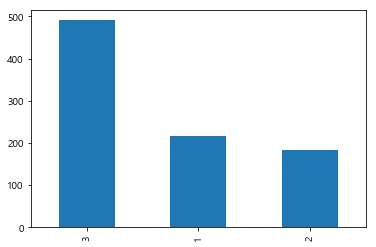

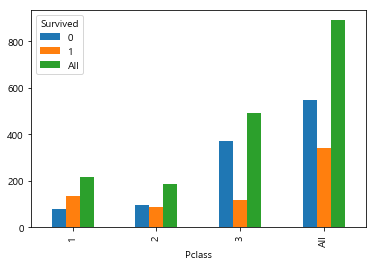

In [151]:
data_df['Pclass'].value_counts().plot(kind = "bar")
ct_pclass = pd.crosstab( data_df.Pclass, data_df.Survived, margins=True)
ct_pclass.plot.bar()


### Embarked  : Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 / 결측치는 빈도가 가장 높은 것

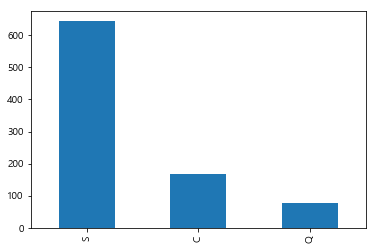

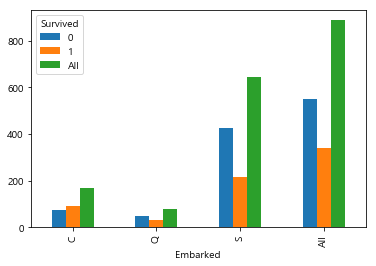

In [152]:
# 어떻게, 얼만큼 분포되어 있는지 -> value_counts 로 개수 파악 & 그래프 그리기
data_df['Embarked'].value_counts().plot(kind = "bar")
ct_embarked = pd.crosstab(data_df.Embarked, data_df.Survived, margins=True)
ct_embarked.plot.bar()

In [153]:
# 결측치 채우기
x_data['Embarked'] = x_data['Embarked'].fillna("C") ## 결측치가 3개라 유의미한 의미 미미
# 데이터 숫자로 바꾸기
x_data['Embarked'] = x_data['Embarked'].replace({'S':0, 'C':1, 'Q':2})

### Sex : Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 / male은 0, female은 1

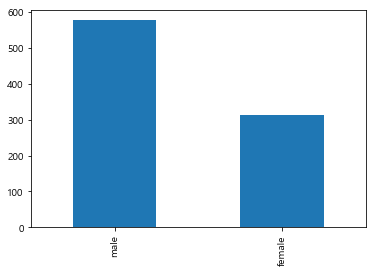

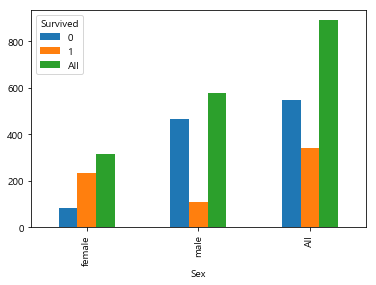

In [154]:
data_df['Sex'].value_counts().plot(kind = "bar")
ct_embarked = pd.crosstab(data_df.Sex, data_df.Survived, margins=True)
ct_embarked.plot.bar()

In [155]:
# Sex 숫자로 변환. male은 0, female은 1
x_data['Sex'] = x_data['Sex'].replace({'male':0, 'female':1})

### SibSp&Parch : SibSp 과 Parch 합해서 새로운 열 만들기

In [156]:
#동승자 수 합치기, 케어하는 사람수는 똑같기 때문
x_data["Passenger"] = x_data["Parch"] + x_data["SibSp"]
x_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Passenger
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1


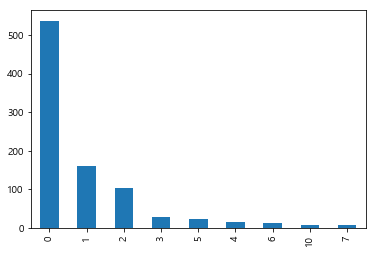

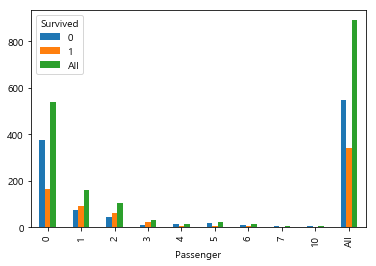

In [157]:
x_data['Passenger'].value_counts().plot(kind = "bar")
ct_passenger = pd.crosstab(x_data.Passenger, data_df.Survived, margins=True)
ct_passenger.plot.bar()

In [158]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null int64
Passenger      891 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 90.6+ KB


### Age : 결측치는 사망자가 가장많은 20대의 평균치로 추가 / 연령대 분류 및 칼럼 추가 / 수치화 및 시각화

In [159]:
# 연령대 결측치 채우기
x_data['Age'] = x_data['Age'].fillna(28) 
x_data['Age'].head(5)

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [160]:
# 연령대  분류하고 칼럼 추가해서 표시하기
age1 = pd.cut(x_data['Age'], bins=[0,9,19,29,39,49,59,69,79,89],labels = ['0이상~10미만','10이상~20미만','20이상~30미만','30이상~40미만','40이상~50미만'
                                                                     ,'50이상~60미만','60이상~70미만','70이상~80미만','80이상~90미만'])
                              # [미포함,포함]                                
age1 # 연령대분류

0      20이상~30미만
1      30이상~40미만
2      20이상~30미만
3      30이상~40미만
4      30이상~40미만
5      20이상~30미만
6      50이상~60미만
7       0이상~10미만
8      20이상~30미만
9      10이상~20미만
10      0이상~10미만
11     50이상~60미만
12     20이상~30미만
13     30이상~40미만
14     10이상~20미만
15     50이상~60미만
16      0이상~10미만
17     20이상~30미만
18     30이상~40미만
19     20이상~30미만
20     30이상~40미만
21     30이상~40미만
22     10이상~20미만
23     20이상~30미만
24      0이상~10미만
25     30이상~40미만
26     20이상~30미만
27     10이상~20미만
28     20이상~30미만
29     20이상~30미만
         ...    
861    20이상~30미만
862    40이상~50미만
863    20이상~30미만
864    20이상~30미만
865    40이상~50미만
866    20이상~30미만
867    30이상~40미만
868    20이상~30미만
869     0이상~10미만
870    20이상~30미만
871    40이상~50미만
872    30이상~40미만
873    40이상~50미만
874    20이상~30미만
875    10이상~20미만
876    20이상~30미만
877    10이상~20미만
878    20이상~30미만
879    50이상~60미만
880    20이상~30미만
881    30이상~40미만
882    20이상~30미만
883    20이상~30미만
884    20이상~30미만
885    30이상~40미만
886    20이상~30미만
887    10이상~20미만
888    20이상~30

In [161]:
# 연령대 칼럼 추가하기
x_data['연령대'] = age1
x_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Passenger,연령대
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,NaN,0,1,20이상~30미만


In [162]:
# 연령대 수치화하기
age2 = pd.cut(x_data['Age'], bins=[0,9,19,29,39,49,59,69,79,89],labels = ['0','1','2','3','4','5','6','7','8'])
age2
x_data['Agegroup'] = age2
x_data.head(1)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Passenger,연령대,Agegroup
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,NaN,0,1,20이상~30미만,2


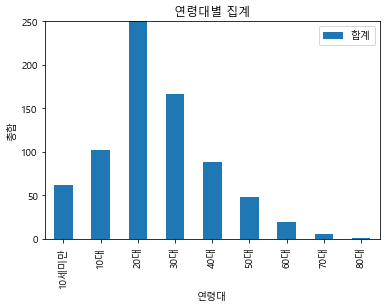

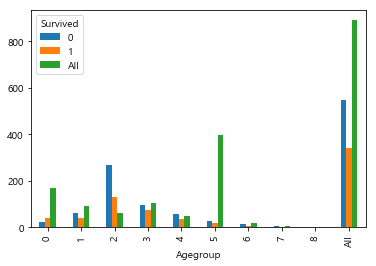

In [163]:
# 연령대 별 분포 시각화
age3 = x_data.groupby(['연령대'])['Name'].count() # 891중 714 # 177은 결측치(Nan)
age3 = age3.reset_index()
age3 = age3.rename(columns = {'Name' : '합계'})
age3
from matplotlib import font_manager, rc 
%matplotlib inline 
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

age3.plot(kind='bar')

plt.title("연령대별 집계")
plt.xlabel("연령대")
plt.ylabel("총합")
plt.xticks([0,1,2,3,4,5,6,7,8],['10세미만','10대','20대','30대','40대','50대','60대','70대','80대']) # x축 단위 바꾸기
plt.ylim(0, 250) # y축 범위 설정
plt.show()

#crosstab
ct_age = pd.crosstab(x_data.Agegroup, data_df.Survived, margins=True)
ct_age.plot.bar()

In [164]:
x_data.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Passenger,연령대,Agegroup
0,1,0,3,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.2500,NaN,0,1,20이상~30미만,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.2833,C85,1,1,30이상~40미만,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.9250,NaN,0,0,20이상~30미만,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.1000,C123,0,1,30이상~40미만,3
4,5,0,3,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.0500,NaN,0,0,30이상~40미만,3
5,6,0,3,"Moran, Mr. James",0,28.00,0,0,330877,8.4583,NaN,2,0,20이상~30미만,2
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.00,0,0,17463,51.8625,E46,0,0,50이상~60미만,5
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.00,3,1,349909,21.0750,NaN,0,4,0이상~10미만,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.00,0,2,347742,11.1333,NaN,0,2,20이상~30미만,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.00,1,0,237736,30.0708,NaN,1,1,10이상~20미만,1


### Fare 


In [165]:
# 그룹화해서 새 열에 저장하기
def Farechanger(data):  
    if data < 100:
        return 0
    elif 100 <= data < 200:
        return 1
    elif 200 <= data < 300:
        return 2
    elif 300 <= data < 400:
        return 3
    elif 400 <= data < 500:
        return 4
    else :
        return 5 
    

x_data['Faregroup'] = x_data['Fare'].apply(Farechanger)
x_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Passenger,연령대,Agegroup,Faregroup
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,NaN,0,1,20이상~30미만,2,0


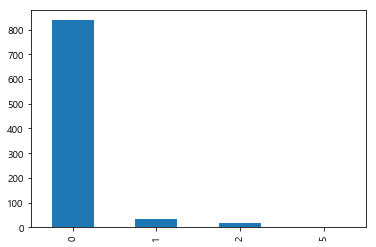

In [166]:
x_data['Faregroup'].value_counts().plot(kind = "bar")

### 2) 불필요한 칼럼 삭제

In [167]:
# 필요없는 칼럼 삭제
del x_data['PassengerId']
del x_data['Name']
del x_data['Age']
del x_data['SibSp']
del x_data['Parch']
del x_data['Ticket']
del x_data['Cabin']
del x_data['Fare']
del x_data['연령대']
del x_data['Faregroup']

In [168]:
x_data.head(3)

,Survived,Pclass,Sex,Embarked,Passenger,Agegroup
0,0,3,0,0,1,2
1,1,1,1,1,1,3
2,1,3,1,0,0,2


In [170]:
del x_data['Survived']
x_data.head(10)


KeyError: 'Survived'

In [171]:
x_data.head(100)
# x_data.to_excel("new_age.xlsx") # 피클로 저장할시 오류 떠서 엑셀로 저장

,Pclass,Sex,Embarked,Passenger,Agegroup
0,3,0,0,1,2
1,1,1,1,1,3
2,3,1,0,0,2
3,1,1,0,1,3
4,3,0,0,0,3
5,3,0,2,0,2
6,1,0,0,0,5
7,3,0,0,4,0
8,3,1,0,2,2
9,2,1,1,1,1


In [172]:
# # 피클로 백업
# import pickle
# with open("x_data.pickle","wb") as fw:
#     pickle.dump(x_data, fw)

In [173]:
# with open("y_data.pickle","wb") as fw:
#     pickle.dump(y_data, fw)

## 3. 모델 적용 프로세스 및 결과 / 3개의 기본 모델 선택 (SVC, KNN, 의사결정나무)
## Train - Test split (비율을 7:3, seed는 0 )
## Create model instance variable 
## Train the model


In [174]:
#모델 적용 프로세스 및 이슈 사항

# - 풀어내려는 문제의 종류와 데이터의 타입(형태,수)에 따른 ML 알고리즘 선택 
# - 50개 이상의 데이터베이스, Category, labeled data
# - 최종적으로 Classification에서 SVC, KNN, Kernel 선택
# - SVC와 Kernel은 중복되는 것이 있어서 Kernel 대신에 의사결정나무로 선택
# - 최종 3개의 모델 : SVC, KNN, 의사결정나무

In [175]:
# 어레이로 바꿔주기
test = np.array(pd.DataFrame(x_data, columns=[
'Pclass',  'Sex',   'Passenger', 'Agegroup',
]))
target = np.array(pd.DataFrame(y_data, columns=['Survived']))
# feature 선택. 슬라이스로 가능. 
#우선 전채 넣어 보기

X = test
Y = target

In [176]:
# tr이랑 test set 나누기
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)

## 1)KNN 모델 ( y_train : 0.836 / y_test : 0.821 )

In [177]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [178]:
# 필요한 library import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [179]:
# 빈 객체 만들기
from sklearn import neighbors, datasets
knn = neighbors.KNeighborsClassifier(6) # K-Neighbors & 클러스터 분류 (Classifier)


In [180]:
# 모델학습시키기
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [181]:
print("Accuracy on Training set: {:.3f}".format(knn.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(knn.score(x_test, y_test)))

Accuracy on Training set: 0.807
Accuracy on Test set: 0.795


In [182]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined

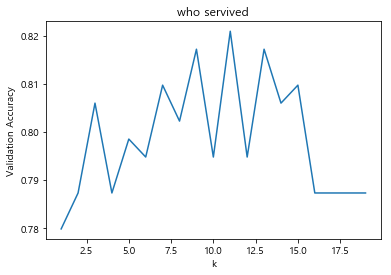

In [183]:
# K값을 바꿔서 비교하기


import matplotlib.pyplot as plt
k_list = range(1,20)
accuracies = []
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(x_train, y_train)
    accuracies.append(classifier.score(x_test, y_test))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()

In [184]:
knn = neighbors.KNeighborsClassifier(11) 
knn.fit(x_train, y_train)
print('{:.3f}'.format(knn.score(x_train, y_train)))
print('{:.3f}'.format(knn.score(x_test, y_test)))

0.836
0.821


## 2)SVC모델 ( y_train : 0.846 / y_test : 0.825)

In [191]:
from sklearn.svm import SVC

svc = SVC(C=15.0)
svc.fit(x_train, y_train)

# Accuracy Test
print("Accuracy on Training set: {:.3f}".format(svc.score(x_train,y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(x_test, y_test)))

Accuracy on Training set: 0.846
Accuracy on Test set: 0.825


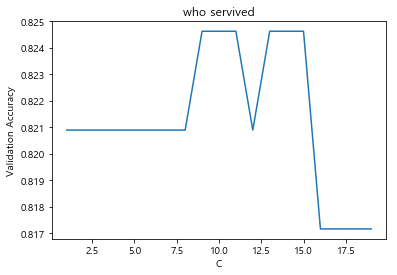

In [190]:
# C값 바꿔서 비교하기

c_list = range(1,20)
accuracies = []
for c in c_list:
    svc = SVC(C = c)
    svc.fit(x_train, y_train)
    accuracies.append(svc.score(x_test, y_test))
plt.plot(c_list, accuracies)
plt.xlabel("C")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()

## 3)의사결정나무 ( y_train : 0.860  / y_test : 0.810)

In [192]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats # statistics
from sklearn.tree import DecisionTreeClassifier

In [193]:
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(x_train, y_train)
dt_prediction = dt_clf.predict(x_test)

print("Accuracy on Training set: {:.3f}".format(dt_clf.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(dt_clf.score(x_test, y_test)))

Accuracy on Training set: 0.860
Accuracy on Test set: 0.810


In [194]:
# 트리 시각화
!pip install pydotplus
import pydotplus 

In [195]:
feature_names = x_data.columns.tolist()
feature_names = feature_names[0:4]
target_name = (['Death', 'Survived'])

from sklearn import tree
dt_dot_data = tree.export_graphviz(dt_clf, out_file = None,
                                  feature_names = feature_names,
                                  class_names = target_name,
                                  filled = True, rounded = True,
                                  special_characters = True)


dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

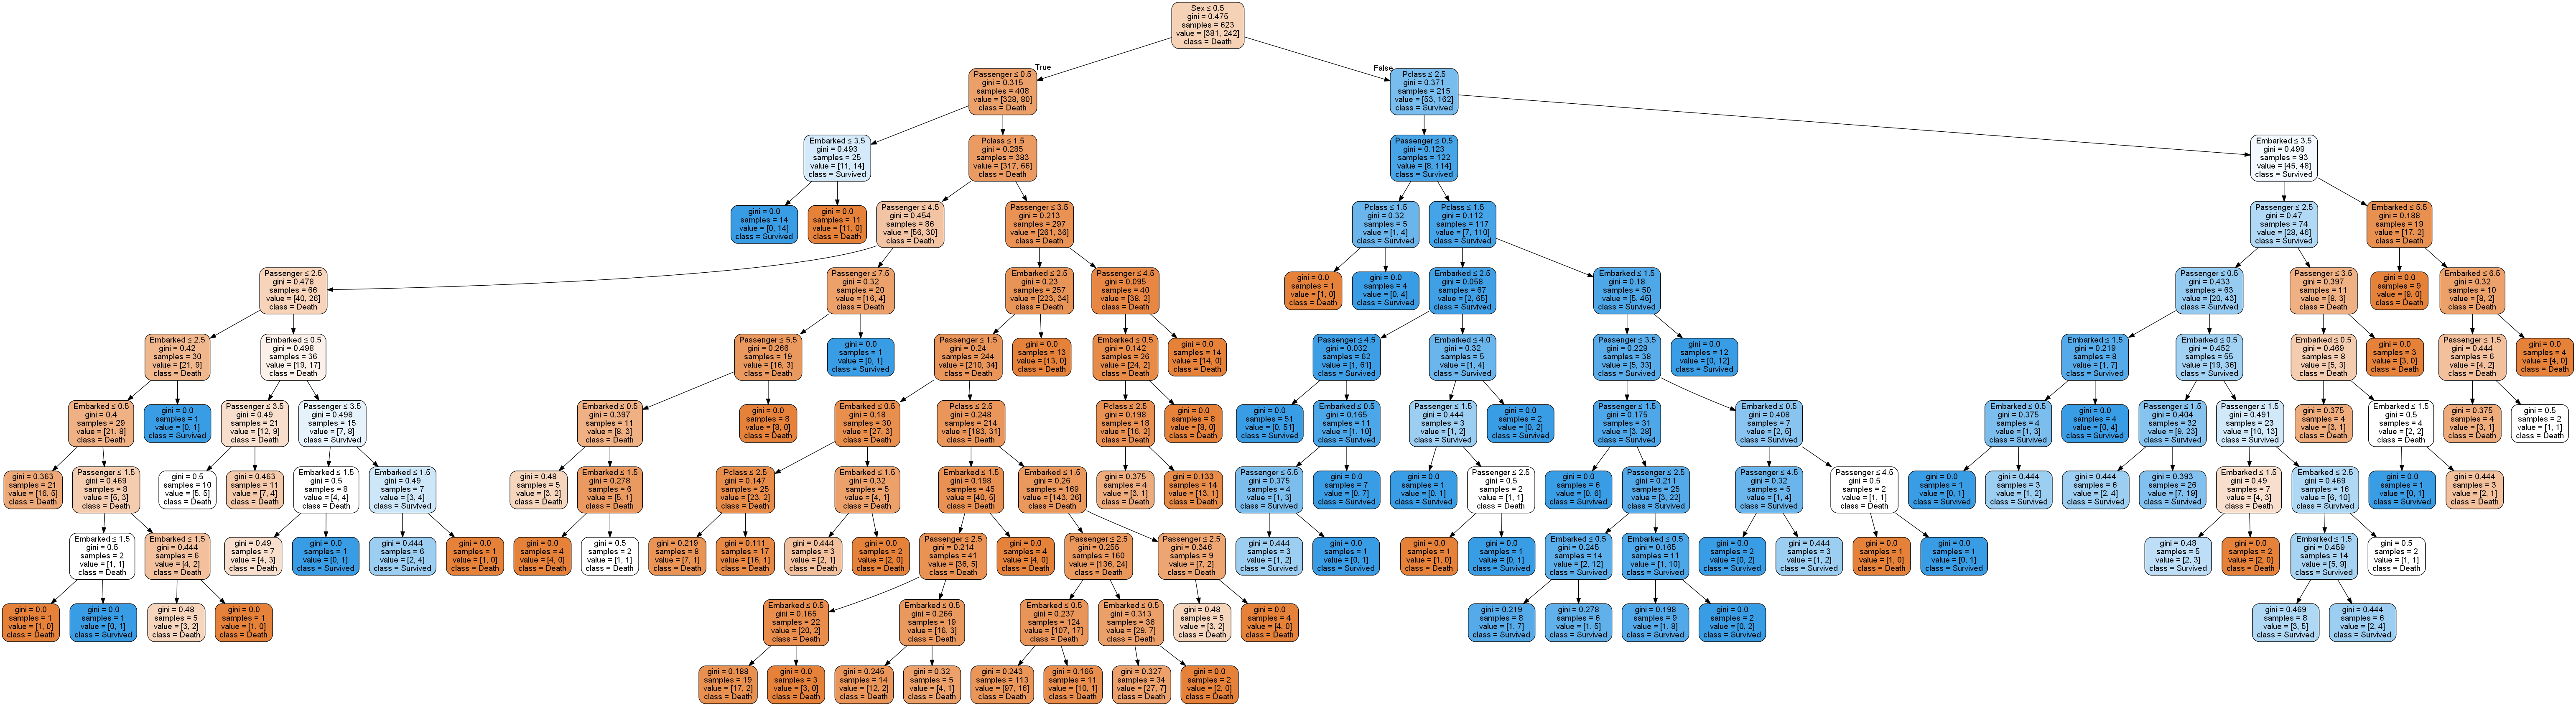

In [196]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from IPython.display import Image
Image(dt_graph.create_png())

## 4)XGBOOST ( y_train : 0.836 / y_test : 0.821 )

In [141]:
from IPython.display import Image

![title](install.png)

 xgboost를 사용하기 위해선 따로 설치를 해줘야한다 <br/>
 아나콘다 실행후, conda install -c anaconda py-xgboost 입력후. y

In [132]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, XGBModel
from xgboost import plot_importance, plot_tree
from sklearn import model_selection

In [200]:
xgb = XGBClassifier(n_estimators= 500, learning_rate=0.1, max_depth= 4)
xgb = xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)

print("Accuracy on Training set: {:.3f}".format(xgb.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(xgb.score(x_test, y_test)))

Accuracy on Training set: 0.854
Accuracy on Test set: 0.813


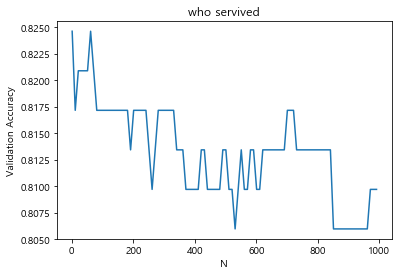

In [205]:
# N 값 바꿔 비교

n_list = range(1,1000, 10)
accuracies = []
for k in n_list:
    xgb = XGBClassifier(n_estimators= k, learning_rate=0.1, max_depth= 4)
    xgb = xgb.fit(x_train, y_train)
    accuracies.append(xgb.score(x_test, y_test))
plt.plot(n_list, accuracies)
plt.xlabel("N")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()

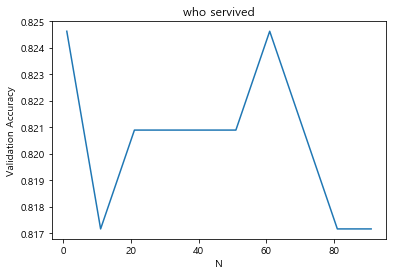

In [206]:
# 범위 좁혀서 비교

n_list = range(1,100, 10)
accuracies = []
for k in n_list:
    xgb = XGBClassifier(n_estimators= k, learning_rate=0.1, max_depth= 4)
    xgb = xgb.fit(x_train, y_train)
    accuracies.append(xgb.score(x_test, y_test))
plt.plot(n_list, accuracies)
plt.xlabel("N")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()

In [207]:
xgb = XGBClassifier(n_estimators= 60, learning_rate=0.1, max_depth= 4)
xgb = xgb.fit(x_train, y_train)
print('{:.3f}'.format(knn.score(x_train, y_train)))
print('{:.3f}'.format(knn.score(x_test, y_test)))

0.836
0.821


## 5) Random Forest ( y_train : 0.856 / y_test : 0.825 )

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

In [208]:
forest = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [209]:
print("Accuracy on Training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(forest.score(x_test, y_test)))

Accuracy on Training set: 0.851
Accuracy on Test set: 0.825


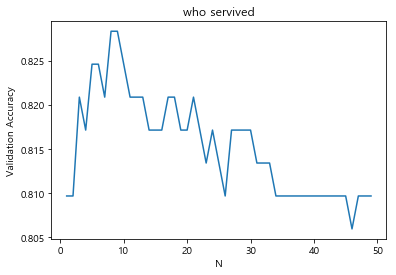

In [211]:
n_list = range(1,50)
accuracies = []
for k in n_list:
    forest = RandomForestClassifier(n_estimators=k, n_jobs=-1, random_state=42)
    forest.fit(x_train, y_train)
    accuracies.append(forest.score(x_test, y_test))
plt.plot(n_list, accuracies)
plt.xlabel("N")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()

In [212]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
forest.fit(x_train, y_train)
print("Accuracy on Training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(forest.score(x_test, y_test)))

Accuracy on Training set: 0.856
Accuracy on Test set: 0.825


## 4. 모델 간 성능비교 / Predict on test data & Check the result with metrics

In [83]:
# 1)KNN 모델 ( y_train : 0.836 / y_test : 0.821 )
# 2)SVC모델 ( y_train : 0.846 / y_test : 0.825)
# 3)의사결정나무 ( y_train : 0.860 / y_test : 0.810)
# 4)XGBOOST ( y_train : 0.836 / y_test : 0.821 )
# 5) Random Forest ( y_train : 0.856 / y_test : 0.825 )

In [ ]:
# KNN 모델
import matplotlib.pyplot as plt
k_list = range(1,20)
accuracies = []
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(x_train, y_train)
    accuracies.append(classifier.score(x_test, y_test))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()
knn = neighbors.KNeighborsClassifier(11) 
knn.fit(x_train, y_train)
print("Accuracy on Training set: {:.3f}".format(knn.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(knn.score(x_test, y_test)))

In [ ]:
#SVC 모델
c_list = range(1,20)
accuracies = []
for c in c_list:
    svc = SVC(C = c)
    svc.fit(x_train, y_train)
    accuracies.append(svc.score(x_test, y_test))
plt.plot(c_list, accuracies)
plt.xlabel("C")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()
svc = SVC(C=15.0)
svc.fit(x_train, y_train)
print("Accuracy on Training set: {:.3f}".format(svc.score(x_train,y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(x_test, y_test)))

In [ ]:
# xgboost
n_list = range(1,100, 10)
accuracies = []
for k in n_list:
    xgb = XGBClassifier(n_estimators= k, learning_rate=0.1, max_depth= 4)
    xgb = xgb.fit(x_train, y_train)
    accuracies.append(xgb.score(x_test, y_test))
plt.plot(n_list, accuracies)
plt.xlabel("N")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()
xgb = XGBClassifier(n_estimators= 60, learning_rate=0.1, max_depth= 4)
xgb = xgb.fit(x_train, y_train)
print("Accuracy on Training set: {:.3f}".format(knn.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(knn.score(x_test, y_test)))

In [ ]:
# Random Forest
n_list = range(1,50)
accuracies = []
for k in n_list:
    forest = RandomForestClassifier(n_estimators=k, n_jobs=-1, random_state=42)
    forest.fit(x_train, y_train)
    accuracies.append(forest.score(x_test, y_test))
plt.plot(n_list, accuracies)
plt.xlabel("N")
plt.ylabel("Validation Accuracy")
plt.title("who servived")
plt.show()
forest = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
forest.fit(x_train, y_train)
print("Accuracy on Training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(forest.score(x_test, y_test)))